El objetivo principal de los métodos Monte Carlo aplicados a estadística bayesiana es 
construir muestras de la densidad de probabilidad posterior.
En el caso de Metropolis-Hastings la exploración se hace dando pasos en el espacio de parámetros, 
el lugar de llegada de cada paso (que puede ser rechazadoo aceptado) se *adivina* sin tener en cuenta
la forma del prior. 
La información del prior solamente se utiliza para aceptar o rechazar el paso propuesto.

Esto puede ser condiderado como una falla, o al menos una elección que no es óptima. Sería deseable 
usar toda la información disponible en cada momento, incluso al momento de proponer un nuevo lugar en la cadena.

Los métodos de Monte Carlo Hamiltoniano buscan una mejora haciendo que la propuesta de un nuevo 
punto en la cadena se haga a partir de una **trayectoria** en el espacio de parámetros. Esta trayectoria se encuentra "dirigida" por el prior.

Antes de entrar de lleno en la formulación del Monte Carlo Hamiltoniano vamos a hacer
un breve repaso sobre la formulación Hamiltoniana de la mecánica y algunos métodos numéricos
asociados.

# Mecánica Hamiltoniana 

La mecánica clásica puede ser reescrita en un formalismo matemático conocido como formalismo Hamiltoniano.
Esta reformulación además de ser útil para la mecánica clásica ha sido fundamental para la mecánica
estadística y la mecánica cuántica.

El objeto matemático central en esta formulación es el **Hamiltoniano**, $\mathcal{H}$.
El Hamiltoniano es una función de las posiciones ($q$) y los momentos ($p$) que describen el sistema que nos interesa. Una vez tenemos el Hamiltoniano en función de $p$ y $q$ podemos encontrar su evolución temporal usando las ecuaciones de Hamilton

$$
\frac{\partial p}{\partial t} = -\frac{\partial \mathcal{H}}{\partial q}
$$

$$
\frac{\partial q}{\partial t} = +\frac{d\mathcal{H}}{\partial p}
$$

En los casos que nos van a interesar el Hamiltoniano corresponde a la energia total del sistema, 
$\mathcal{H}= T+V$ donde $T$ es la energia cinetica y $V$ es la energia potencial.

# Ejemplo 5.1

Una partícula de masa $m$ en un plano bidimensional está conectada por un resorte a un punto fijo.
Para simplificar vamos a tomar el origen del sistema de coordenadas como el punto donde está fijo un extremo del resorte. El otro extremo del resorte, donde está nuestra partícula de masa $m$, tiene coordenadas $x,y$.

La energia cinética se puede escribir en coordenadas cartesianas como $ T = p_x^2/2m + p_y^2/2m$ mientras que la energia potencial es $V=kx^2/2 + ky^2/2$. En este caso el Hamiltoniano del sistema es:

$$
\mathcal{H} = \frac{1}{2m}p_x^2 + \frac{1}{2m}p_y^2 + \frac{k}{2}x^2 + \frac{k}{2}y^2.
$$

# Integracion de las ecuaciones de Hamilton

El objetivo ahora es resolver las ecuaciones de hamilton numericamente.
Esto quiere decir que vamos a encontrar $p$ y $q$ como funciones del tiempo.
Dado que esto implica resolver numericamente ecuaciones diferenciales acopladas de primer orden
es necesario dar las condiciones iniciales para todos los $p$ y $q$.

En terminos de diferencias finitas podemos reescribir las ecuaciones de Hamilton como

$$
p_{n+1} = p_{n} -\frac{\partial\mathcal{H}}{\partial q}\Delta t,
$$

$$
q_{n+1} = q_{n} + \frac{\partial \mathcal{H}}{\partial p}\Delta t.
$$

La primera ecuacion recibe el nombre de **kick** (es como un golpe que cambia el momentum) y la segunda ecuacion el de **drift** (es como un movimiento libre a velocidad constante).

## Ejercicio 5.2
Utilizando el mismo ejemplo de antes vamos a resolver las ecuaciones de Hamilton de manera computacional.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def partialH_partialq(p, q, k=1, m=1):
    """Expresion analitica de la derivada del hamiltoniano con respecto a q.
    """
    return k*q

def partialH_partialp(p, q, k=1, m=1):
    """Expresion analitica de la derivada del hamiltoniano con respecto a p.
    """
    return p/m

def kick(p, q, delta_t, k=1, m=1):
    """Cambio en el momentum.
    """
    p_new = p - partialH_partialq(p, q, k=k, m=m) * delta_t
    return p_new

def drift(p, q, delta_t, k=1, m=1):
    """Cambio en la posicion.
    """
    q_new = q + partialH_partialp(p, q, k=k, m=m) * delta_t
    return q_new

def solve(delta_t = 1E-2, n_steps=1000):
    """
    Resuelve las ecuaciones de Hamilton a traves de 
    un metodo leapfrog: kick-drift-kick.
    """
    # condiciones iniciales
    x = [1.0]
    y = [2.0]
    px = [5.0]
    py = [-3.0]
    
    # constante del resorte y masa
    k = 1.0
    m = 1.0
    for i in range(1,n_steps):
        # Primero un nuevo punto con un kick de delta_t/2
        px.append(kick(px[i-1], x[i-1],delta_t/2, k=k, m=m))
        py.append(kick(py[i-1], y[i-1],delta_t/2, k=k, m=m))
        
        # Luego un drift de delta_t con el nuevo momentum 
        x.append(drift(px[i], x[i-1],delta_t, k=k, m=m))
        y.append(drift(py[i], y[i-1],delta_t, k=k, m=m))
        
        # Finalmente otro kick de delta_t/2 para fijar el momentum 
        px[i] = kick(px[i], x[i],delta_t/2, k=k, m=m)
        py[i] = kick(py[i], y[i],delta_t/2, k=k, m=m)
    return np.array(x), np.array(y), np.array(px), np.array(py)

In [2]:
x, y, px, py = solve()

Text(0,0.5,'x')

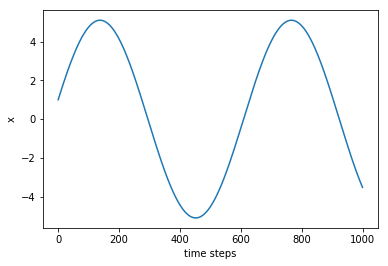

In [3]:
plt.plot(x)
plt.xlabel('time steps')
plt.ylabel('x')

Text(0,0.5,'y')

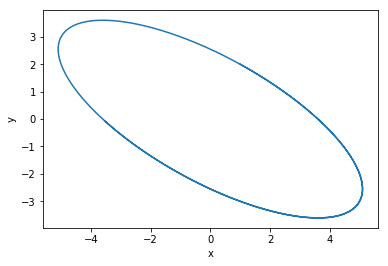

In [4]:
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('y')

En este caso el resultado era el esperado: movimiento armonico bidimensional.

# Monte Carlo Hamiltoniano

¿Qué tiene que ver todo esto con Monte Carlo Hamiltoniano? La idea principal es que 
la distribución de probabilidad que va ser muestreada va a jugar el rol del potencial 
dentro del Hamiltoniano. Una metáfora podría ser la siguiente: un punto de la cadena se le asigna un momento aleatorio para que se mueva dentro de la distribución de probabilidad y generar una nueva propuesta. Para seleccionar si la propuesta se aprueba se sigue el método tradicional de Metropolis Hastings.

Más precisamente, si la distribución que se desea muestrear es $F(q)$, entonces vamos a definir el 
siguiente Hamiltoniano 

$$
\mathcal{H} = \frac{p^2}{2m} -  \log (F(q)) 
$$

y en cada paso de la cadena de Markov generamos un momento inicial con $p$ tomado de una distribucion Gaussiana y $q$ del valor presente de la cadena. Evolucionamos la solucion del Hamiltoniano por $n_{steps}$ con un $\Delta t$ determinado, cambiamos el signo de $p$ (por que? ver la pag. 40 https://arxiv.org/pdf/1701.02434.pdf), para finalmente evaluar si el nuevo lugar en la cade debe aceptarse o no comparando el Hamiltoniano (i.e. la energía) en los dos puntos de interés.

# Ejercicio 5.2

Vamos a construir una cadena de Markov que samplea una distribución Gaussiana con desviación estándar `sigma` usando el método Hamiltoniano.

In [5]:
def pdf_to_sample(q, sigma):
    return exp(-0.5*q**2/sigma**2)

def log_pdf_to_sample(q, sigma):
    return -0.5*q**2/sigma**2

def gradient_log_pdf_to_sample(q, sigma):
    return -q/sigma**2

def leapfrog(q,p, sigma, delta_t=1E-1, niter=5):
    q_new = q
    p_new = p
    for i in range(niter):
        p_new = p_new + 0.5 * delta_t * gradient_log_pdf_to_sample(q_new, sigma) #kick
        q_new = q_new + delta_t * p_new #drift
        p_new = p_new + 0.5 * delta_t * gradient_log_pdf_to_sample(q_new, sigma) #kick
    return q_new, p_new

def H(q,p, sigma):
    K = 0.5 * p * p
    U = -log_pdf_to_sample(q, sigma)
    return K + U

def MCMC(nsteps):
    q = np.zeros(nsteps)
    p = np.zeros(nsteps)
    p[0] = np.random.normal(0,1)
    q[0] = np.random.normal(0,1)
    sigma = 0.1
    for i in range(1,nsteps):
        p[i] = np.random.normal(0,1)
        q_new, p_new = leapfrog(q[i-1],p[i-1], sigma) # la propuesta se hace con leapfrog
        p_new = -p_new #negamos a p para que la propuesta sea simetrica.
        E_new = H(q_new, p_new, sigma) # En lugar de evaluar la pdf se evalua la energia.
        E_old = H(q[i-1], p[i-1], sigma)
        alpha = min(1.0,np.exp(-(E_new - E_old))) # Se comparan las dos energias
        beta = np.random.random()
        if beta < alpha:
            q[i] = q_new
        else:
            q[i] = q[i-1]
    return q

In [8]:
q_chain = MCMC(10000)

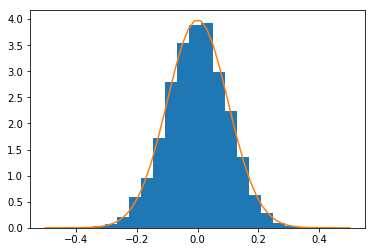

In [9]:
x = np.linspace(-0.5, 0.5)
sigma = 0.1
y = (1.0/(sigma * np.sqrt(2*np.pi))) * np.exp(-0.5*(x/sigma)**2)

a = plt.hist(q_chain[500:], bins=20, density=True)
plt.plot(x,y)


# Ejercicio 5.1

Resuelva el ejercicio (ajuste cuadrático) del notebook anterior usando Monte Carlo Hamiltoniano. En ese casos lo más recomendable es calcular las derivadas de manera numérica y considerar además un prior gaussiano (para que el posterior sea continuo y pueda derivarse sin problemas).

<Container object of 3 artists>

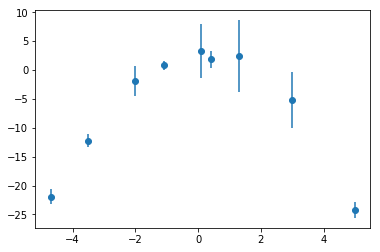

In [12]:
x_obs = np.array([-2.0,1.3,0.4,5.0,0.1, -4.7, 3.0, -3.5,-1.1])
y_obs = np.array([ -1.931,   2.38,   1.88,  -24.22,   3.31, -21.9,  -5.18, -12.23,   0.822])
sigma_y_obs = np.array([ 2.63,  6.23, -1.461, 1.376, -4.72,  1.313, -4.886, -1.091,  0.8054])
plt.errorbar(x_obs, y_obs, yerr=sigma_y_obs, fmt='o')


In [3]:
def model(x,a,b,c):
    return a*x**2 + b*x + c

def loglikelihood(x_obs, y_obs, sigma_y_obs, a, b, c):
    d = y_obs -  model(x_obs, a,b,c)
    d = d/sigma_y_obs
    d = -0.5 * np.sum(d**2)
    return d

def logprior(a, b, c):
    p = -np.inf
    if a <= 5 and a >-100 and b >-20 and b<20 and c>-10 and c<10:
        p = 0.0
    return p

In [13]:
N = 200000
lista_a = [np.random.random()]
lista_b = [np.random.random()]
lista_c = [np.random.random()]
logposterior = [loglikelihood(x_obs, y_obs, sigma_y_obs, lista_a[0], lista_b[0], lista_c[0]) + logprior(lista_a[0], lista_b[0], lista_c[0])]

sigma_delta_a = 1.0
sigma_delta_b = 1.0
sigma_delta_c = 0.5

for i in range(1,N):
    propuesta_a  = lista_a[i-1] + np.random.normal(loc=0.0, scale=sigma_delta_a)
    propuesta_b  = lista_b[i-1] + np.random.normal(loc=0.0, scale=sigma_delta_b)
    propuesta_c  = lista_c[i-1] + np.random.normal(loc=0.0, scale=sigma_delta_c)

    logposterior_viejo = loglikelihood(x_obs, y_obs, sigma_y_obs, lista_a[i-1], lista_b[i-1], lista_c[i-1]) + logprior(lista_a[i-1], lista_b[i-1], lista_c[i-1])
    logposterior_nuev o = loglikelihood(x_obs, y_obs, sigma_y_obs, propuesta_a, propuesta_b, propuesta_c) + logprior(propuesta_a, propuesta_b, propuesta_c)

    r = min(1,np.exp(logposterior_nuevo-logposterior_viejo))
    alpha = np.random.random()
    if(alpha<r):
        lista_a.append(propuesta_a)
        lista_b.append(propuesta_b)
        lista_c.append(propuesta_c)
        logposterior.append(logposterior_nuevo)
    else:
        lista_a.append(lista_a[i-1])
        lista_b.append(lista_b[i-1])
        lista_c.append(lista_c[i-1])
        logposterior.append(logposterior_viejo)
        
lista_a = np.array(lista_a)
lista_b = np.array(lista_b)
lista_c = np.array(lista_c)
logposterior = np.array(logposterior)

/home/mauro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


In [95]:
ua=-1
ub=0
uc=2
sa=5
sb=5
sc=5

In [96]:
def model(x,a,b,c):
    return a*x**2 + b*x + c

In [150]:
def leapfrog(qa,pa,qb,pb,qc,pc, delta_t=1E-8, niter=5):
    qa_new = qa
    pa_new = pa
    qb_new = qb
    pb_new = pb
    qc_new = qc
    pc_new = pc
    
    for i in range(niter):
        pa_new = pa_new + 0.5 * delta_t * gradient_log_a(qa_new,qb_new,qc_new) #kick
        qa_new = qa_new + delta_t * pa_new #drift
        pa_new = pa_new + 0.5 * delta_t * gradient_log_a(qa_new,qb_new,qc_new) #kick
        
        pb_new = pb_new + 0.5 * delta_t * gradient_log_b(qa_new,qb_new,qc_new) #kick
        qb_new = qb_new + delta_t * pb_new #drift
        pb_new = pb_new + 0.5 * delta_t * gradient_log_b(qa_new,qb_new,qc_new) #kick
    
        pc_new = pc_new + 0.5 * delta_t * gradient_log_c(qa_new,qb_new,qc_new) #kick
        qc_new = qc_new + delta_t * pc_new #drift
        pc_new = pc_new + 0.5 * delta_t * gradient_log_c(qa_new,qb_new,qc_new) #kick
    return qa_new, pa_new, qb_new, pb_new, qc_new, pc_new

def gradient_log_a(qa,qb,qc):
    return np.log(1/(sa*(2*np.pi)**0.5))*(qa-ua)/sa**2    - sum((y_obs-model(x_obs,qa,qb,qc))*(x_obs**2/sigma_y_obs**2))
    
def gradient_log_b(qa,qb,qc):
    return np.log(1/(sa*(2*np.pi)**0.5))*(qa-ua)/sa**2 - sum((y_obs-model(x_obs,qa,qb,qc))*(x_obs/sigma_y_obs**2))

def gradient_log_c(qa,qb,qc):
    return np.log(1/(sa*(2*np.pi)**0.5))*(qa-ua)/sa**2 - sum((y_obs-model(x_obs,qa,qb,qc))*(1/sigma_y_obs**2))

def log_gausiana(x,u,sigma):
    return np.log(1/(sigma*(2*np.pi)**0.5))*(x-u)**2/(2*sigma**2)

def log_likelyhood(a,b,c):
    return -0.5*sum(y_obs - model(x_obs,a,b,c)/sigma_y_obs)
    

def H(qa,qb,qc,pa,pb,pc):
    K = (pa**2+pb**2+pc**2)/2
    U = -log_likelyhood(qa,qb,qc)-log_gausiana(qa,ua,sa)-log_gausiana(qb,ub,sb)-log_gausiana(qc,uc,sc)
    return K + U

    

def MCMC(nsteps):
    qa = np.zeros(nsteps)
    pa = np.zeros(nsteps)
    qb = np.zeros(nsteps)
    pb = np.zeros(nsteps)
    qc = np.zeros(nsteps)
    pc = np.zeros(nsteps)
    
    
    pa[0] = np.random.normal(0,1)
    qa[0] = -1#np.random.normal(0,1)#np.random.normal(ua,sa)
    pb[0] = np.random.normal(0,1)
    qb[0] = 0.15#np.random.normal(0,1)#np.random.normal(ub,sb)
    pc[0] = np.random.normal(0,1)
    qc[0] = 3#np.random.normal(0,1)#np.random.normal(uc,sc)
    
    
    for i in range(1,nsteps):
        pa[i] = np.random.normal(0,1)*4
        pb[i] = np.random.normal(0,1)*4
        pc[i] = np.random.normal(0,1)*4
                            
#         qa_new, pa_new = leapfroga(qa[i-1],pa[i-1]) # la propuesta se hace con leapfrog
#         qb_new, pb_new = leapfrogb(qb[i-1],pb[i-1]) # la propuesta se hace con leapfrog
#         qc_new, pc_new = leapfrogc(qc[i-1],pc[i-1]) # la propuesta se hace con leapfrog
        
        qa_new, pa_new, qb_new, pb_new, qc_new, pc_new = leapfrog(qa[i-1],pa[i-1],qb[i-1],pb[i-1],qc[i-1],pc[i-1])
                            
        pa_new = -pa_new #negamos a p para que la propuesta sea simetrica.
        pb_new = -pb_new #negamos a p para que la propuesta sea simetrica.
        pc_new = -pc_new #negamos a p para que la propuesta sea simetrica.
        
#         E_new = H(q_new, p_new, sigma)# En lugar de evaluar la pdf se evalua la energia.
        E_new = H(qa_new,qb_new,qc_new,pa_new,pb_new,pc_new)# En lugar de evaluar la pdf se evalua la energia.
#         E_old = H(q[i-1], p[i-1], sigma)
        E_old = H(qa[i-1],qb[i-1],qc[i-1], pa[i-1],pb[i-1],pc[i-1])
        alpha = min(1.0,np.exp(-(E_new - E_old))) # Se comparan las dos energias
        beta = np.random.random()
#         print(np.exp(-(E_new - E_old)))
        if beta < alpha:
            qa[i] = qa_new
            qb[i] = qb_new
            qc[i] = qc_new
        else:
            qa[i] = qa[i-1]
            qb[i] = qb[i-1]
            qc[i] = qc[i-1]
    return qa,qb,qc

In [151]:
qa,qb,qc = MCMC(50000)

(array([ 1958.,  2774.,  3792.,  7716.,  3596.,  2311.,  9766., 10406.,
         5651.,  2030.]),
 array([2.99998517, 2.99999129, 2.99999742, 3.00000354, 3.00000966,
        3.00001579, 3.00002191, 3.00002803, 3.00003416, 3.00004028,
        3.00004641]),
 <a list of 10 Patch objects>)

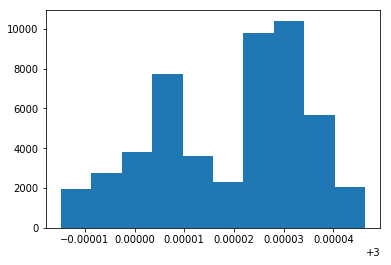

In [152]:
plt.hist(qc)

In [153]:
param_a = np.mean(qa)
param_b = np.mean(qb)
param_c = np.mean(qc)

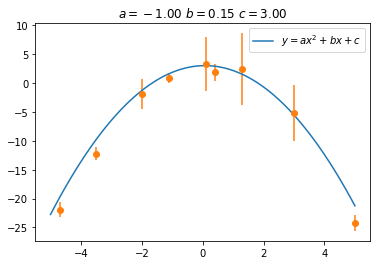

In [154]:
x = np.array([-2.0,1.3,0.4,5.0,0.1, -4.7, 3.0, -3.5,-1.1])
z = np.array([ -1.931,   2.38,   1.88,  -24.22,   3.31, -21.9,  -5.18, -12.23,   0.822])
sigma_z = ([ 2.63,  6.23, -1.461, 1.376, -4.72,  1.313, -4.886, -1.091,  0.8054])
xs = np.linspace(-5,5,100)
ys = model(xs,param_a,param_b,param_c)
plt.plot(xs,ys, label= r"$y=ax^2+bx+c$")
plt.legend()
plt.title(r"$a={:.2f}\ b={:.2f}\ c={:.2f}$".format(param_a,param_b,param_c))
plt.errorbar(x, z, yerr=sigma_z, fmt='o')
plt.savefig("results.pdf")